# iEEG Data

Analyze iEEG data.

## Dataset Details

This notebook analyzes data from the openly available MNI dataset.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_ieeg_file, load_ieeg_all
from apm.run import run_measures
from apm.analysis import (compute_all_corrs, unpack_corrs,
                          compute_corrs_to_feature, compute_diffs_to_feature)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS
from apm.methods import (autocorr_decay_time, hurst, dfa, higuchi_fd, hjorth_complexity,
                         lempelziv, sample_entropy, perm_entropy, specparam, irasa)
from apm.methods.settings import (AC_DECAY_PARAMS, HURST_PARAMS, DFA_PARAMS, HFD_PARAMS,
                                  HJC_PARAMS, LZ_PARAMS, SA_ENT_PARAMS, PE_ENT_PARAMS)
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Set Up Paths

In [4]:
# Define the data folder
data_path = Path('/Users/tom/Data/External/iEEG/MNI/Wakefulness_AllRegions/')

In [5]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'ieeg'

In [6]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['ieeg_all_corrs.p', 'ieeg_results.p']

## Settings

In [7]:
# Define data information
fs = 200

In [8]:
# Set max time to load
max_time = 30

In [9]:
# Add plot kwargs
dot_kwargs = {
    's' : 24,
    'alpha' : 0.7,
}

In [10]:
# Settings for saving figures
SAVE_FIG = False
FIGPATH = db.figs_path / '53_ieeg_data'

## Load Data

In [11]:
# Get the list of available files
files = get_files(data_path)

In [12]:
# Check the number of files
n_files = len(files)
print('Number of files: {}'.format(n_files))

Number of files: 38


In [13]:
# Load all data files
all_data = load_ieeg_all(files, data_path, max_time)

In [14]:
# Check data size
n_chs, n_times = all_data.shape
print('Number of channels: {}'.format(n_chs))

Number of channels: 1772


## Data Checks

In [19]:
# Set example subject index
subj_ind = 27

In [20]:
# Set example channel index
chi = 1

In [21]:
# Load an example file of iEEG data
times, data = load_ieeg_file(files[subj_ind], data_path, max_time)

In [22]:
# Check data shape
n_chs, n_times = data.shape
n_chs, n_times

(123, 6000)

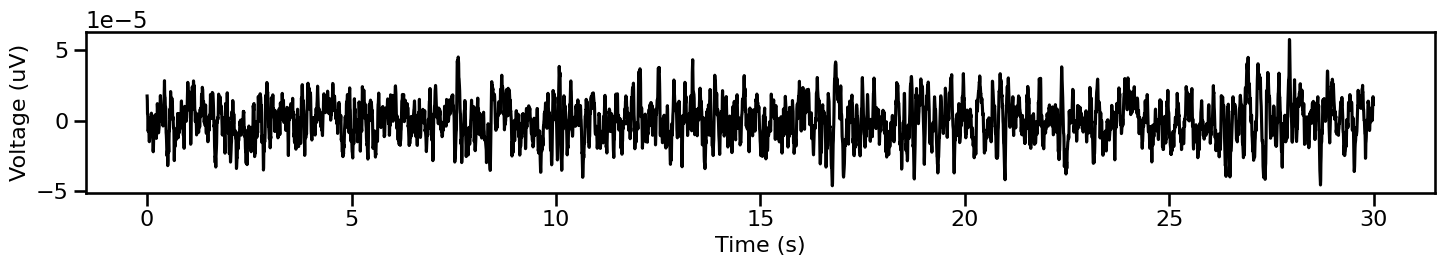

In [23]:
# Plot an example time series (full time)
plot_time_series(times, data[chi, :])

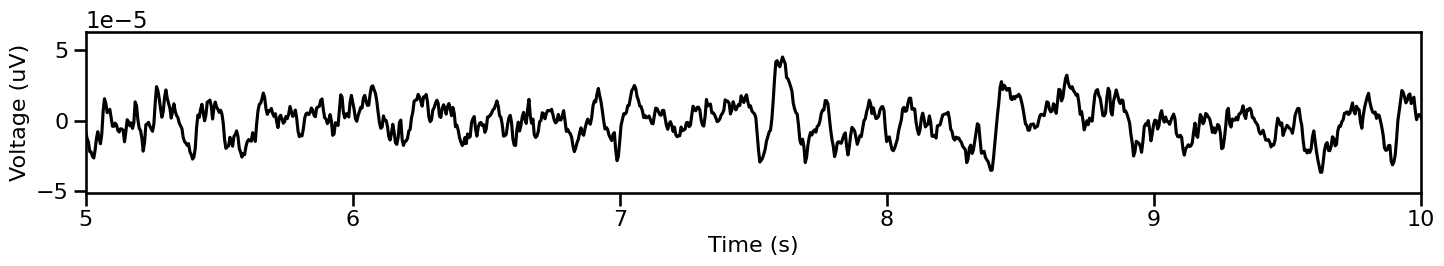

In [24]:
# Plot a zoomed in segment of a time series
plot_time_series(times, data[chi, :], xlim=[5, 10])

In [25]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[chi, :], fs, nperseg=2*fs, noverlap=fs)

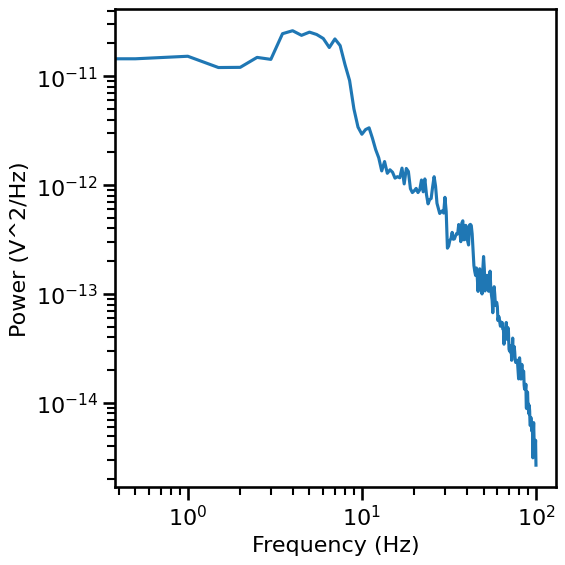

In [26]:
# Plot the power spectrum
plot_power_spectra(freqs, powers)

## Load Results

In [27]:
# Load precomputed aperiodic measure results
results = load_pickle('ieeg_results', LOADPATH)

In [28]:
# Check size of computed results [n_subjs, n_chs]
results['dfa'].shape

(25,)

### Check Measures & Labels

In [29]:
# Check list of computed measures
print(list(results.keys()))

['autocorr_decay_time', 'dfa', 'higuchi_fd', 'hjorth_complexity', 'lempelziv', 'sample_entropy', 'perm_entropy', 'specparam', 'irasa']


In [31]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

In [32]:
# Collect labels for time series measures
ts_labels = [LABELS[meas] for meas in ts_measures]

### Compute Correlations

In [33]:
# Compute correlations across all pairs of methods
all_corrs = compute_all_corrs(results)

#### Compare exponent measures

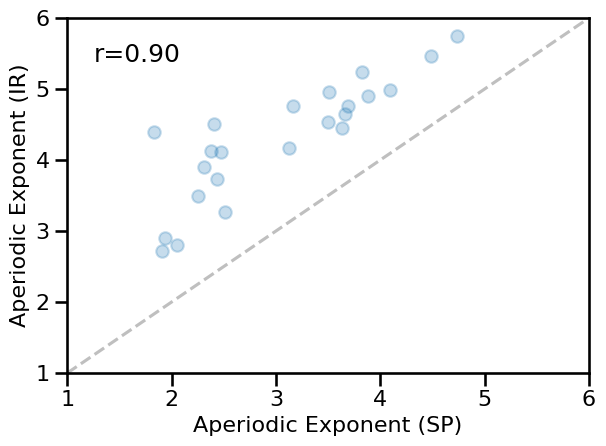

In [34]:
# Compare aperiodic exponent from specparam & IRASA
plot_dots(results['specparam'], results['irasa'], alpha=0.25, tposition='tl',
          xlim=[1, 6], ylim=[1, 6], expected=[1, 6],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='ieeg_exp_exp' + EXT, file_path=FIGPATH)

In [35]:
# Check correlation between exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.901  CI[+0.732, +0.974],  p=0.000


#### Compare exponent to other measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


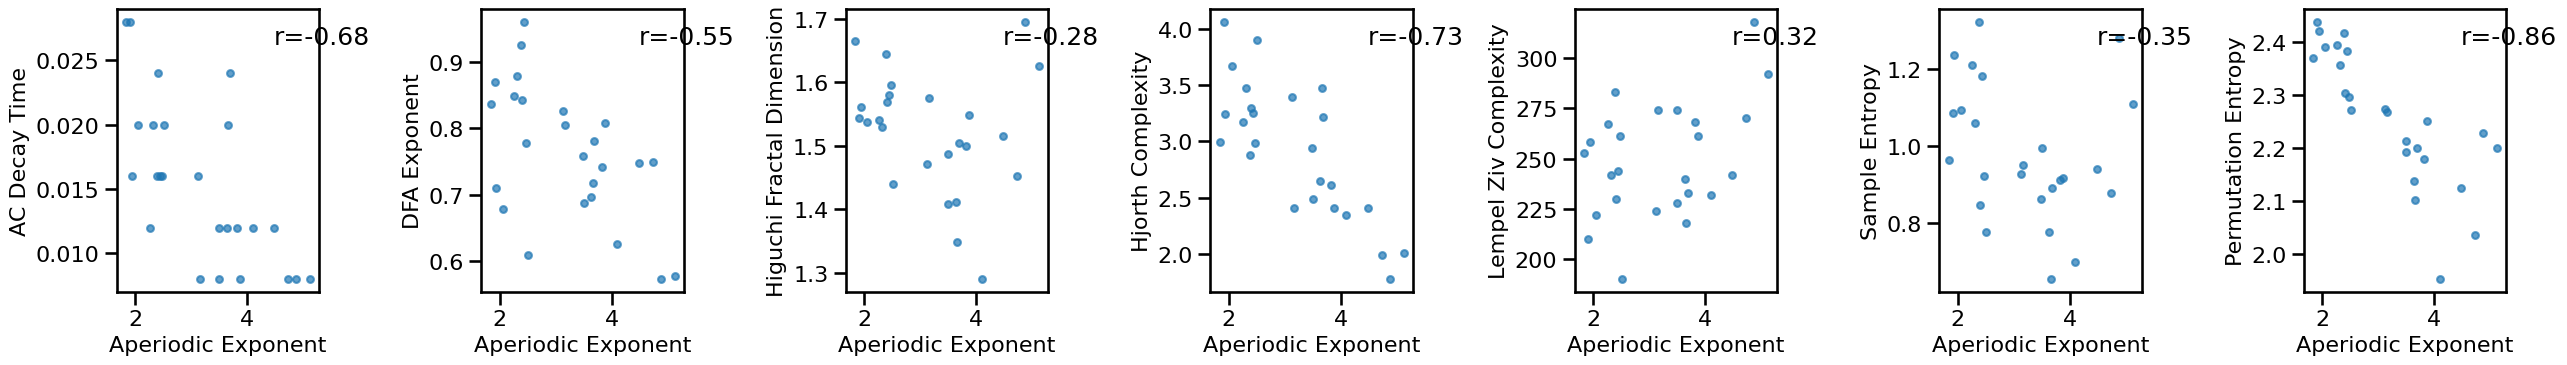

In [36]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.4)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + EXT))

In [37]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa'][meas]))

autocorr_decay_time
    SP-EXP:   r=-0.682  CI[-0.881, -0.353],  p=0.000
    IR-EXP:   r=-0.659  CI[-0.838, -0.326],  p=0.000
dfa
    SP-EXP:   r=-0.548  CI[-0.821, -0.140],  p=0.005
    IR-EXP:   r=-0.424  CI[-0.800, +0.051],  p=0.035
higuchi_fd
    SP-EXP:   r=-0.279  CI[-0.675, +0.192],  p=0.176
    IR-EXP:   r=-0.092  CI[-0.481, +0.326],  p=0.661
hjorth_complexity
    SP-EXP:   r=-0.725  CI[-0.894, -0.428],  p=0.000
    IR-EXP:   r=-0.828  CI[-0.934, -0.590],  p=0.000
lempelziv
    SP-EXP:   r=+0.319  CI[-0.121, +0.661],  p=0.121
    IR-EXP:   r=+0.493  CI[+0.069, +0.775],  p=0.012
sample_entropy
    SP-EXP:   r=-0.353  CI[-0.715, +0.085],  p=0.083
    IR-EXP:   r=-0.248  CI[-0.649, +0.212],  p=0.231
perm_entropy
    SP-EXP:   r=-0.862  CI[-0.950, -0.656],  p=0.000
    IR-EXP:   r=-0.796  CI[-0.905, -0.579],  p=0.000


### Compare Time Series Measures to Each Other

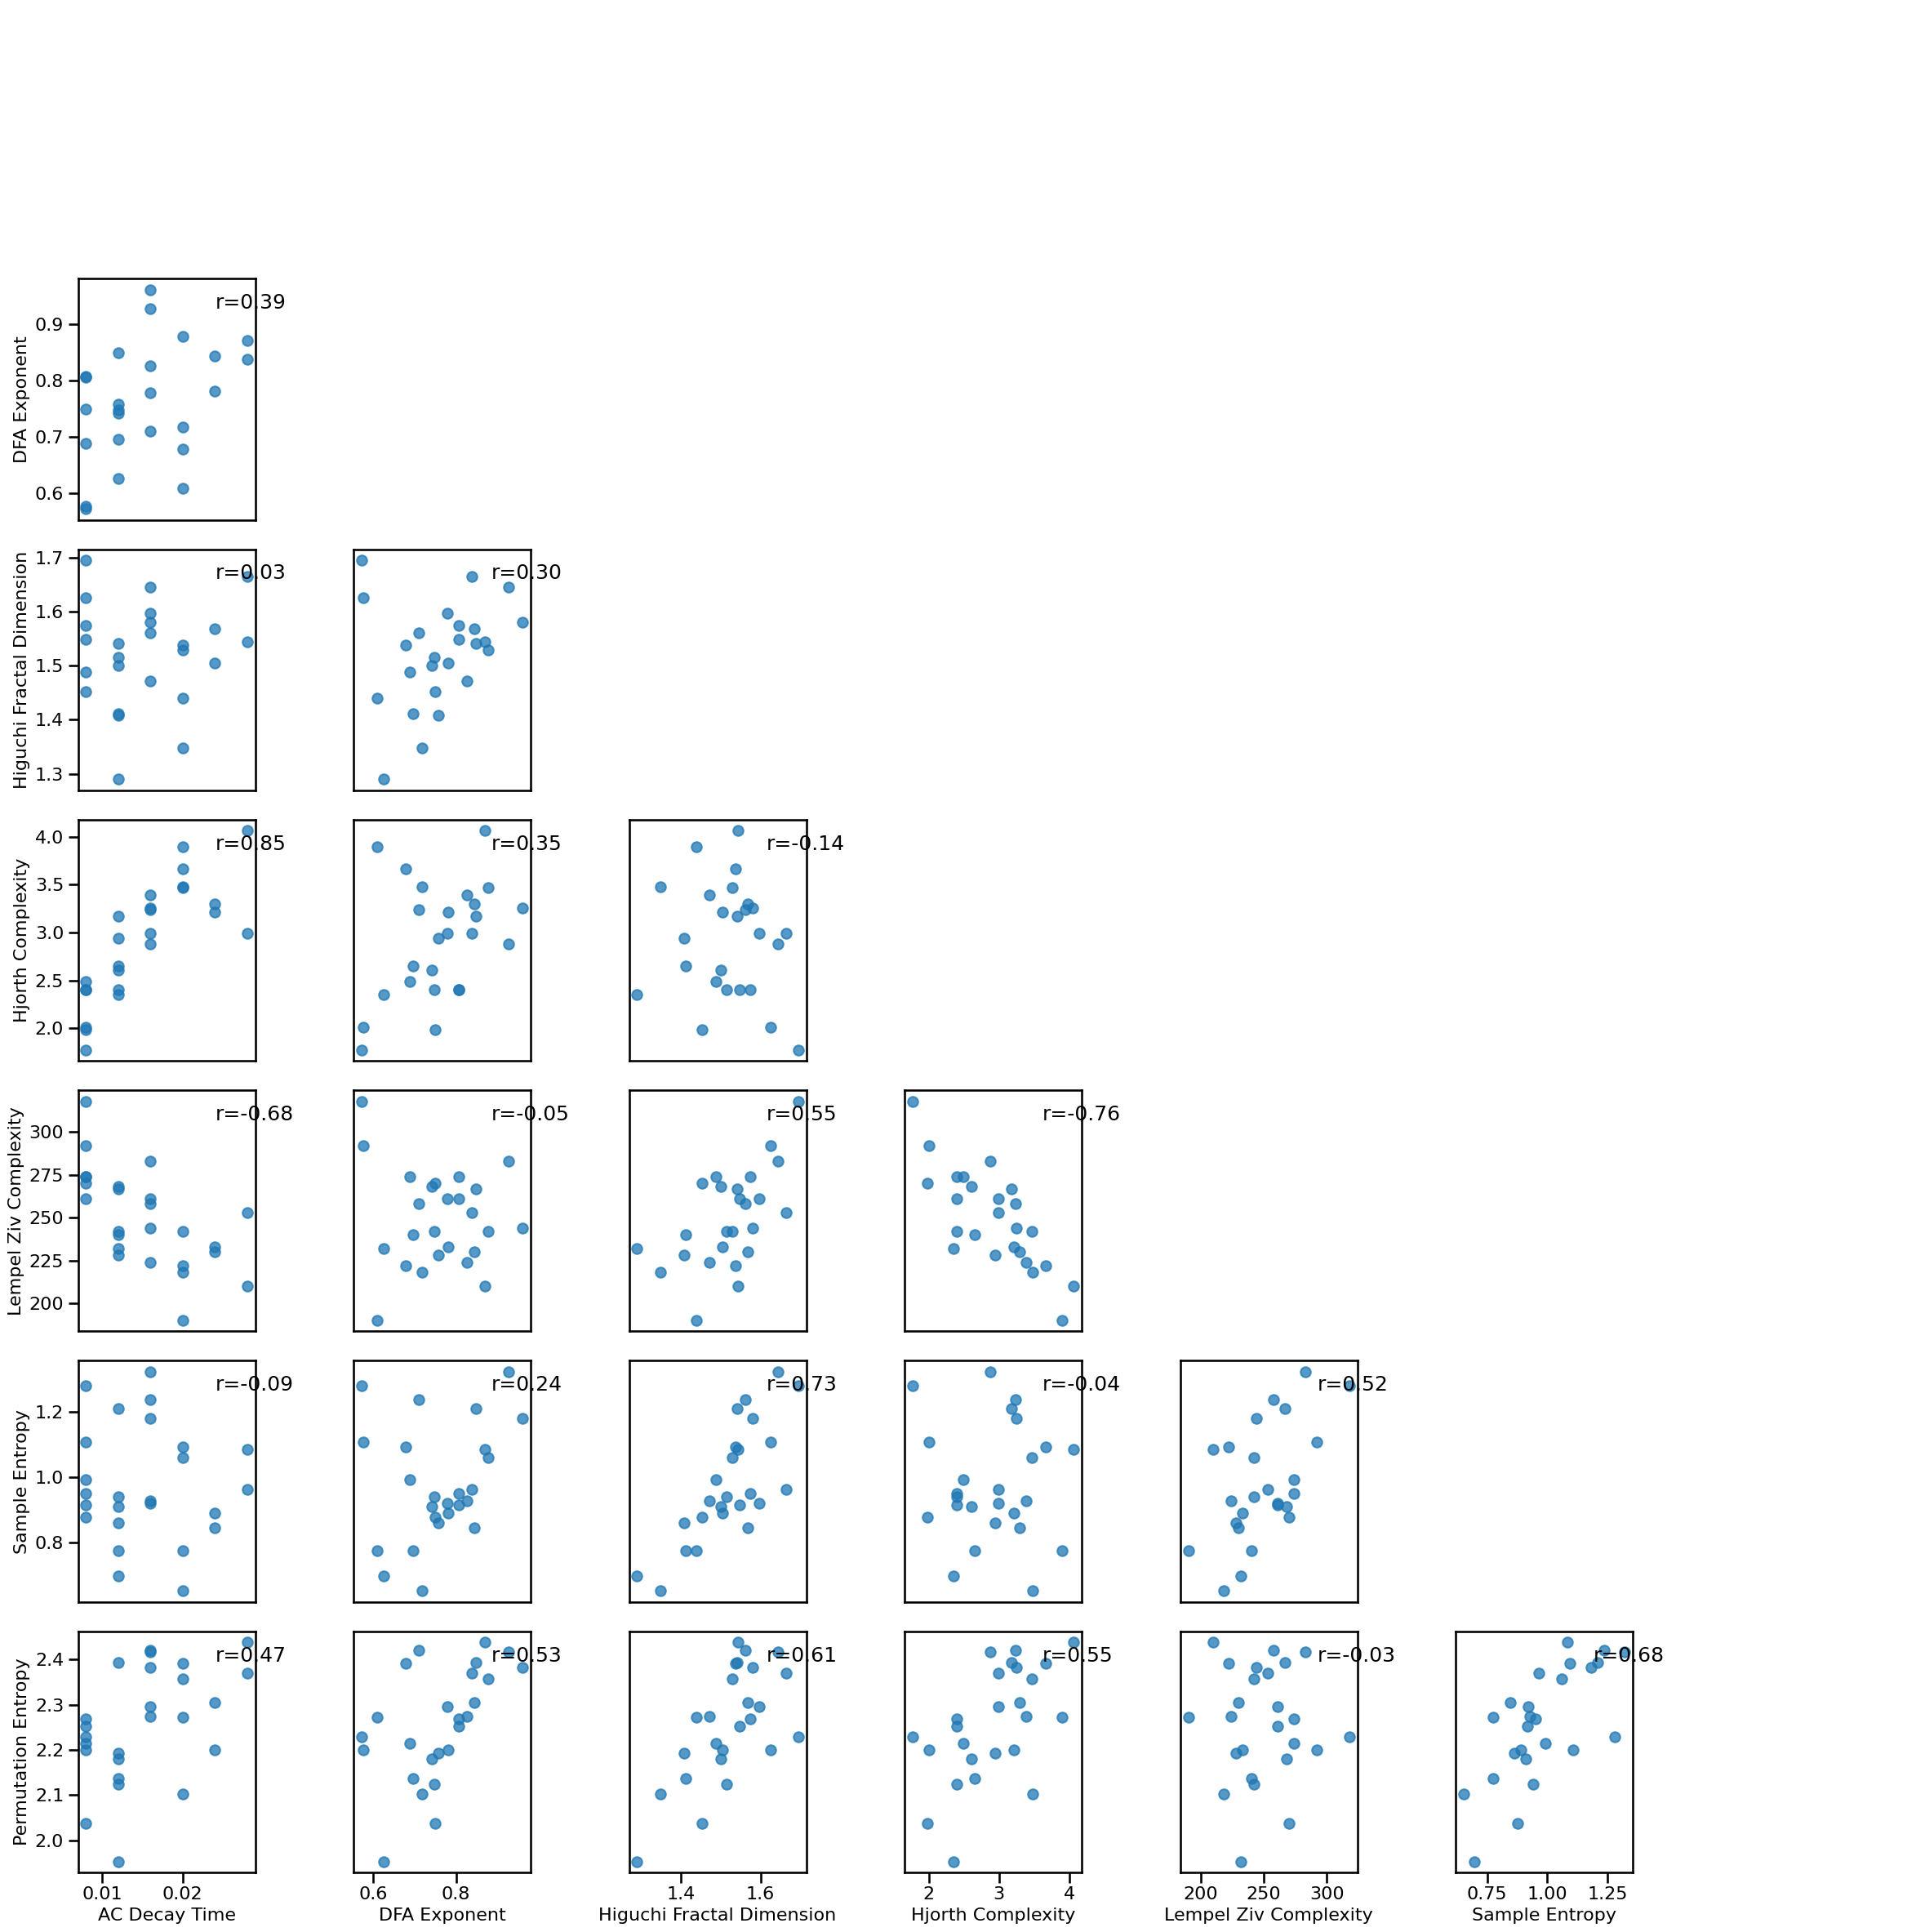

In [38]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

### Correlations

In [39]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures}

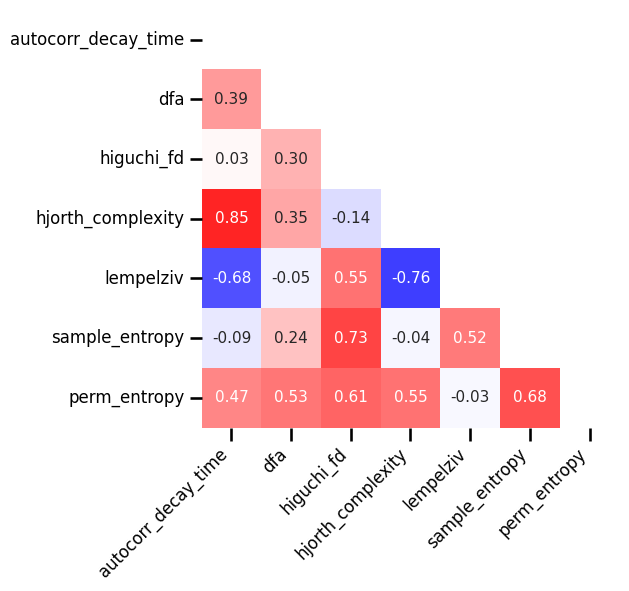

In [40]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(unpack_corrs(all_corrs_ts), cbar=False, figsize=(6, 6),
                 xticklabels=ts_measures, yticklabels=ts_measures)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + EXT))

In [41]:
# Extract the correlations between specparam and time domain measures
exp_corrs_subjs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T

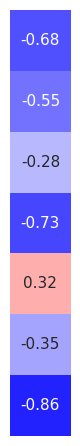

In [42]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_subjs' + EXT, file_path=FIGPATH)

## Compare to Alpha

In [43]:
# # Define periodic measures to compute
# peak_measures = {alpha_power : measures[specparam]}

In [44]:
# # Compute periodic measures
# peak_results = run_measures(data, peak_measures)

In [45]:
# # Compute correlations between aperiodic measures and alpha power
# alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [46]:
# # Compute differences between correlations between aperiodic measures and alpha power
# alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [47]:
# # Check the correlations between alpha power and aperiodic measures
# print('Correlations with alpha:')
# for label in alpha_corrs.keys():
#     print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

## Conclusions

The iEEG data broadly replicates analyses on the EEG datasets. 